# Transformação de séries temporais para previsão com modelo linear

Esse notebook é feito com base nesse post:
https://towardsdatascience.com/staying-competitive-with-linear-models-19444bc3698e

A maior diferença está ao final, ao se utilizar uma transformação de potência na variável alvo, além de utilizar variáveis com lag para fazer as previsões.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
pd.options.mode.chained_assignment = None

In [ ]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month'])

In [ ]:
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [ ]:
X = pd.DataFrame(df.index, columns=['n_month'])
y = df['Passengers']

In [ ]:
test_len = 24

X_train, X_test = X.iloc[:-test_len, :], X.iloc[-test_len:, :]
y_train, y_test = y.iloc[:-test_len], y.iloc[-test_len:]
df_train, df_test = df.iloc[:-test_len, :], df.iloc[-test_len:, :]

In [ ]:
mdl = LinearRegression()
mdl.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
preds = mdl.predict(X_train)

Visualizando a série com as vrevisões geradas com o modelo puramente linear.

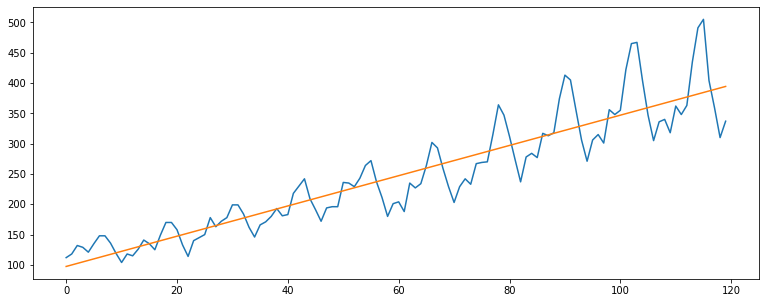

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(X_train, y_train)
plt.plot(X_train, preds)

Métricas R2 e MAE:

In [ ]:
print(mdl.score(X_test, y_test))
print(mean_absolute_error(y_test, mdl.predict(X_test)))

-0.0029625785503968327
54.93759857937666


Adicionando features dos meses:

1 = jan

2 = fev 

3 = mar
...

In [ ]:
X_train['month'] = pd.DatetimeIndex(df_train['Month']).month
X_test['month'] = pd.DatetimeIndex(df_test['Month']).month


In [ ]:
X_train.head()

,n_month,month
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5


In [ ]:
mdl.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
preds = mdl.predict(X_train)

Novas previsões e métricas.

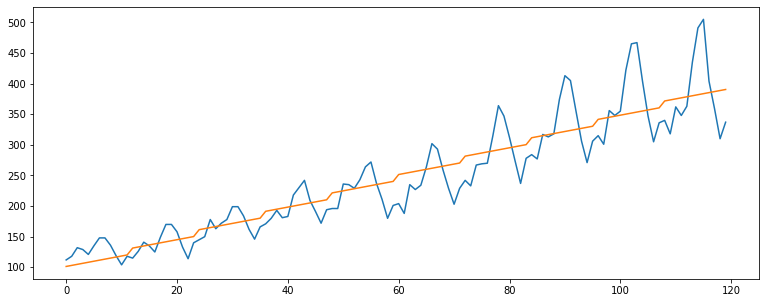

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(X_train['n_month'], y_train)
plt.plot(X_train['n_month'], preds)

As métricas tiveram valores piores do que na rodada passada.

In [ ]:
print(mdl.score(X_test, y_test))
print(mean_absolute_error(y_test, mdl.predict(X_test)))

-0.006146321719005643
55.05042573167572


Adicionando feature com valores binários para os meses.

In [ ]:
X_train = pd.get_dummies(X_train, columns=['month'], prefix='month')
X_test = pd.get_dummies(X_test, columns=['month'], prefix='month')

In [ ]:
X_train.head()

,n_month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0
2,2,0,0,1,0,0,0,0,0,0,0,0,0
3,3,0,0,0,1,0,0,0,0,0,0,0,0
4,4,0,0,0,0,1,0,0,0,0,0,0,0


Recriando e testando o modelo.

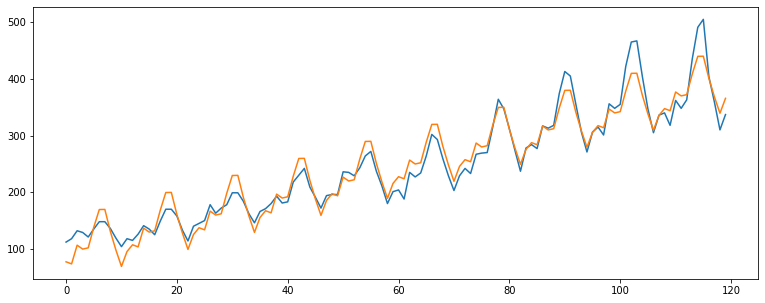

In [ ]:
mdl.fit(X_train, y_train)
preds = mdl.predict(X_train)
plt.figure(figsize=(13, 5))
plt.plot(X_train['n_month'], y_train)
plt.plot(X_train['n_month'], preds)

As métricas melhoraram consideravelmente.

In [ ]:
print(mdl.score(X_test, y_test))
print(mean_absolute_error(y_test, mdl.predict(X_test)))

0.5878148747784182
34.637836700336685


Adicionando uma transformação de potência yeo-johnson à variável objetivo.

In [ ]:
mdl_trans = TransformedTargetRegressor(regressor=mdl, transformer=PowerTransformer())

In [ ]:
mdl_trans.fit(X_train, y_train)
preds = mdl_trans.predict(X_train)

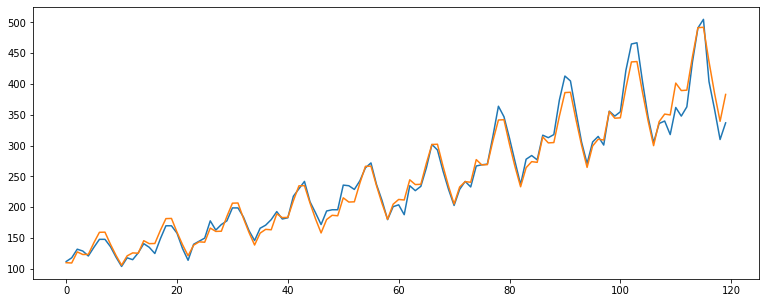

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(X_train['n_month'], y_train)
plt.plot(X_train['n_month'], preds)

In [ ]:
preds_test = mdl_trans.predict(X_test)

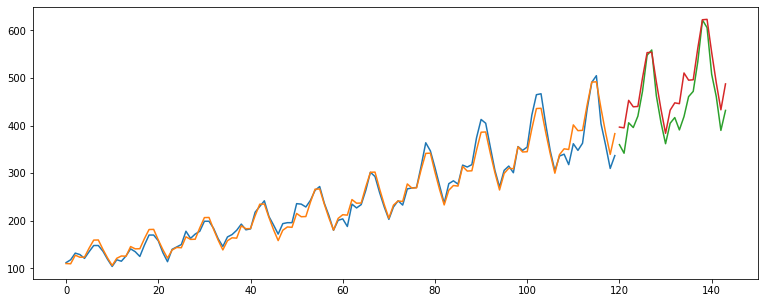

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(X_train['n_month'], y_train)
plt.plot(X_train['n_month'], preds)
plt.plot(X_test['n_month'], y_test)
plt.plot(X_test['n_month'], preds_test)

As métricas melhoraram ainda mais.

In [ ]:
print(mdl_trans.score(X_test, y_test))
print(mean_absolute_error(y_test, mdl_trans.predict(X_test)))

0.7334693000235792
33.45235034645561


Por fim, adicionando variáveis "atrasadas", de 6 meses a 12 meses atras. Isso faz com que as previsões possam ser no máximo 6 meses à frente, a não ser que o modelo seja utilizado recursivamente.

In [ ]:
for lag in range(6, 12):
  df['lag_{}'.format(lag)] = df['Passengers'].shift(lag)

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df.head()

,Month,Passengers,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
11,1949-12-01,118,135.0,121.0,129.0,132.0,118.0,112.0
12,1950-01-01,115,148.0,135.0,121.0,129.0,132.0,118.0
13,1950-02-01,126,148.0,148.0,135.0,121.0,129.0,132.0
14,1950-03-01,141,136.0,148.0,148.0,135.0,121.0,129.0
15,1950-04-01,135,119.0,136.0,148.0,148.0,135.0,121.0


In [ ]:
X = df.drop(['Month', 'Passengers'], axis=1)
X['n_month'] = df.index
y = df['Passengers']

In [ ]:
X_train, X_test = X.iloc[:-test_len, :], X.iloc[-test_len:, :]
y_train, y_test = y.iloc[:-test_len], y.iloc[-test_len:]
df_train, df_test = df.iloc[:-test_len, :], df.iloc[-test_len:, :]

In [ ]:
X_train['month'] = pd.DatetimeIndex(df_train['Month']).month
X_test['month'] = pd.DatetimeIndex(df_test['Month']).month
X_train = pd.get_dummies(X_train, columns=['month'], prefix='month')
X_test = pd.get_dummies(X_test, columns=['month'], prefix='month')

In [ ]:
X_train.head()

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,n_month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
11,135.0,121.0,129.0,132.0,118.0,112.0,11,0,0,0,0,0,0,0,0,0,0,0,1
12,148.0,135.0,121.0,129.0,132.0,118.0,12,1,0,0,0,0,0,0,0,0,0,0,0
13,148.0,148.0,135.0,121.0,129.0,132.0,13,0,1,0,0,0,0,0,0,0,0,0,0
14,136.0,148.0,148.0,135.0,121.0,129.0,14,0,0,1,0,0,0,0,0,0,0,0,0
15,119.0,136.0,148.0,148.0,135.0,121.0,15,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
mdl_trans.fit(X_train, y_train)
preds = mdl_trans.predict(X_train)

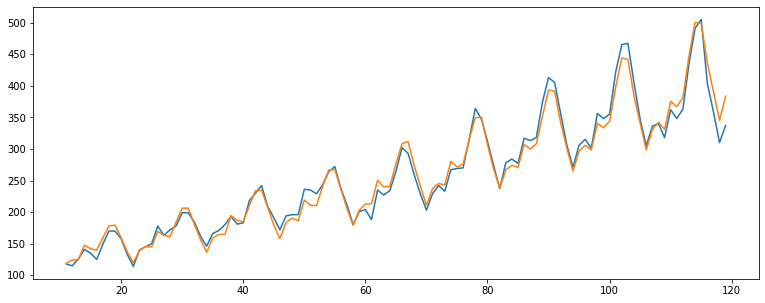

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(X_train['n_month'], y_train)
plt.plot(X_train['n_month'], preds)

In [ ]:
preds_test = mdl_trans.predict(X_test)

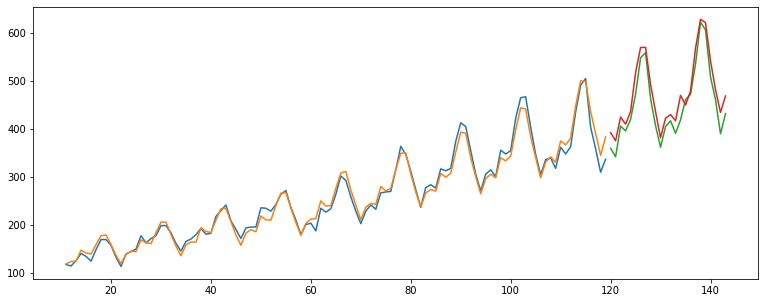

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(X_train['n_month'], y_train)
plt.plot(X_train['n_month'], preds)
plt.plot(X_test['n_month'], y_test)
plt.plot(X_test['n_month'], preds_test)

As métricas mostram ainda mais concordância nos dados de teste.

In [ ]:
print(mdl_trans.score(X_test, y_test))
print(mean_absolute_error(y_test, mdl_trans.predict(X_test)))

0.8670806393037332
24.353705114769003
